In [1]:
import numpy as np
import pandas as pd
import glob
import xarray as xr
import matplotlib.pyplot as plt
from scipy import stats

import sys; sys.path.insert(1, '/home/alessandro/thesis_material/EURECA_scripts')
import os

import geometry as gm
#import conversion as cnv
from func_statistics import compute_pdf_nbin, slopes_r_p, slopes_r_p_onlysub, slopes_r_p_mix, slope_time, slope_maps
import regression
#from coare_functions import *
import meteo
import lcl
import metpy.calc as mpcalc
from metpy.units import units


import cartopy.crs as ccrs
crs = ccrs.PlateCarree()
#from plotmap import plot_background
from plotdistr import * #fb_distribution_npoint, perc_distribution, scatterplot_fit, hist2d
from pdist_fb_distrib_save_fast import *

import warnings; warnings.filterwarnings("ignore")



In [2]:
sys.path.append('/home/alessandro/thesis_material/EURECA_scripts/ABL_BULK/')

import neggers_stevens

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
path = '/venus/tesi_ale/data_bulk/sensitivities/SST_sens_VaryingQFree_fracUstar07_allForcingTerms.pickle'
import pickle

with open(path, 'rb') as handle:
    collect_eq = pickle.load(handle)
    
SST_values = collect_eq['SST values']
collect_eq.pop('SST values')

frac_Ustar = collect_eq['frac_Ustar']
collect_eq.pop('frac_Ustar')

0.7

In [5]:
collect_eq['4.0'].keys()

dict_keys(['M_eq', 'E_eq', 'LHF_eq', 'LHF_CC_eq', 'qs_eq', 'qsat_eq', 'SHF_eq', 'LCL_eq', 'we_dyn_eq', 'h_eq', 'q_eq', 'th_eq', 'U_eq', 'V_eq', 'C_delta_q_eq', 'C_delta_th_eq', 'q_flux_s_eq', 'th_flux_s_eq'])

# equation for q

In [6]:
q_free = '4.0'

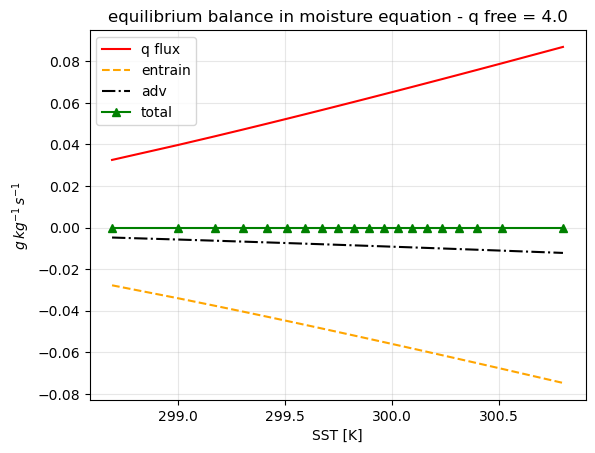

In [7]:
q_flux_s = collect_eq[q_free]['q_flux_s_eq']
E        = collect_eq[q_free]['E_eq']
delta_q  = collect_eq[q_free]['C_delta_q_eq']

h        = collect_eq[q_free]['h_eq']
F_advq = -1.2e-3/86400                 # [kg/kg/s]


plt.plot(SST_values, q_flux_s*1e3, '-r', label='q flux')
plt.plot(SST_values, E*delta_q*1e3, '--', color='orange', label='entrain')
plt.plot(SST_values, h*F_advq*1e3, '-.', color='k', label='adv')
plt.plot(SST_values, (h*F_advq+E*delta_q+q_flux_s)*1e3, '-^', color='green', label='total')
plt.title(f'equilibrium balance in moisture equation - q free = {q_free}')

plt.xlabel('SST [K]')
plt.ylabel(r"$g\,kg^{-1}\,s^{-1}$")
plt.grid(alpha=0.3)
plt.legend()

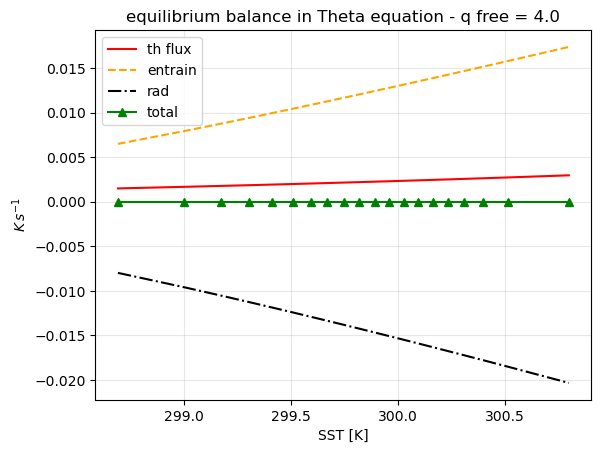

In [8]:
th_flux_s = collect_eq[q_free]['th_flux_s_eq']
E        = collect_eq[q_free]['E_eq']
delta_th  = collect_eq[q_free]['C_delta_th_eq']

h        = collect_eq[q_free]['h_eq']
F_rad = -2.0/86400                # [K/day]


plt.plot(SST_values, th_flux_s, '-r', label='th flux')
plt.plot(SST_values, E*delta_th, '--', color='orange', label='entrain')
plt.plot(SST_values, h*F_rad, '-.', color='k', label='rad')
plt.plot(SST_values, h*F_rad+E*delta_th+th_flux_s, '-^', color='green', label='total')
plt.title(f'equilibrium balance in Theta equation - q free = {q_free}')

plt.xlabel('SST [K]')
plt.ylabel(r"$K\,s^{-1}$")
plt.grid(alpha=0.3)
plt.legend()

# wind equations

In [8]:

# Compute the wind components (to be used as free tropospheric wind) starting from the surface wind used in 
# Neggers et al (2006).
magnitude = 8.75 # [m/s]
angle = 67.5 # [°] clockwise from north
U_free = magnitude*np.sin(angle*np.pi/180)
V_free = magnitude*np.cos(angle*np.pi/180)
print(U_free)
print(V_free)

Omega = 2*np.pi/86400 # [rad/s] Earth rotation.
latitude0 = 10 # degree N
f = Omega * np.sin(latitude0*np.pi/180)

CD = 1/900.                            # drag coefficient.

8.083945909473758
3.348480033194536


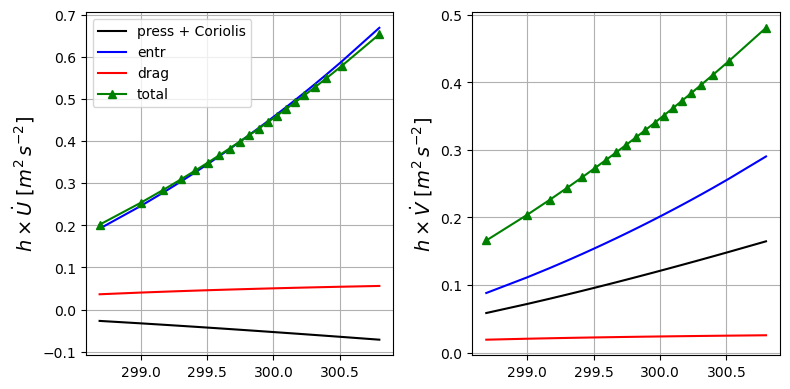

In [9]:

U, V      = collect_eq[q_free]['U_eq'], collect_eq[q_free]['V_eq']
we_dyn    = collect_eq[q_free]['we_dyn_eq']
delta_th  = collect_eq[q_free]['C_delta_th_eq']

h        = collect_eq[q_free]['h_eq']


fig, ax = plt.subplots(1,2,figsize=(8,4))


#######  wind  ######
ax[0].plot(SST_values, h*f*(V-V_free), 'k', label='press + Coriolis')
ax[0].plot(SST_values, we_dyn*(U_free-U),'blue', label='entr')
ax[0].plot(SST_values, -CD*U*np.sqrt(U**2+V**2),'r', label='drag')
ax[0].plot(SST_values, -CD*U*np.sqrt(U**2+V**2) + we_dyn*(U_free-U) + h*f*(V-V_free),'-^', color='green', label='total')
ax[0].set_ylabel(r'$h\times \dot{U}$ [$m^2\,s^{-2}$]',fontsize=14)
#ax[0].set_ylim(0,0.10)
ax[0].grid()

ax[1].plot(SST_values, -h*f*(U-U_free), 'k', label='press + Coriolis')
ax[1].plot(SST_values, we_dyn*(V_free-V),'blue', label='entr')
ax[1].plot(SST_values, -CD*V*np.sqrt(U**2+V**2),'r', label='drag')
ax[1].plot(SST_values, -CD*V*np.sqrt(U**2+V**2) + we_dyn*(V_free-V) + -h*f*(U-U_free),'-^', color='green', label='total')
ax[1].set_ylabel(r'$h\times \dot{V}$ [$m^2\,s^{-2}$]',fontsize=14)
#ax[1].set_ylim(0,0.10)
ax[1].grid()

ax[0].legend(loc='upper left')

plt.tight_layout()

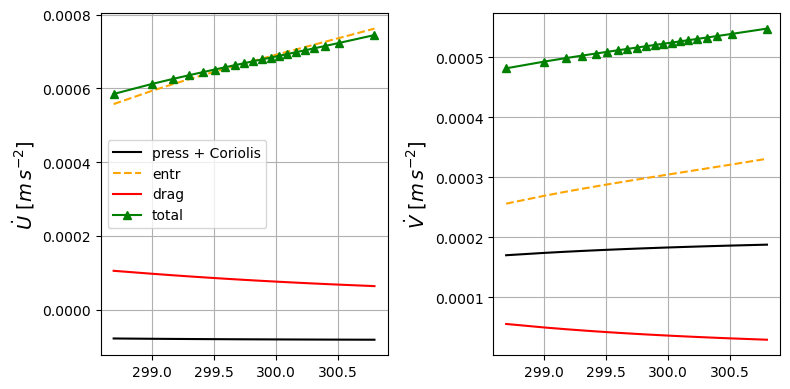

In [10]:

U, V      = collect_eq[q_free]['U_eq'], collect_eq[q_free]['V_eq']
we_dyn    = collect_eq[q_free]['we_dyn_eq']
delta_th  = collect_eq[q_free]['C_delta_th_eq']

h        = collect_eq[q_free]['h_eq']


fig, ax = plt.subplots(1,2,figsize=(8,4))


#######  wind  ######
ax[0].plot(SST_values, f*(V-V_free), 'k', label='press + Coriolis')
ax[0].plot(SST_values, we_dyn*(U_free-U)/h,'--', color='orange', label='entr')
ax[0].plot(SST_values, -CD*U*np.sqrt(U**2+V**2)/h,'r', label='drag')
ax[0].plot(SST_values, -CD*U*np.sqrt(U**2+V**2)/h + we_dyn*(U_free-U)/h + f*(V-V_free),'-^', color='green', label='total')
ax[0].set_ylabel(r'$\dot{U}$ [$m\,s^{-2}$]',fontsize=14)
#ax[0].set_ylim(0,0.10)
ax[0].grid()

ax[1].plot(SST_values, -f*(U-U_free), 'k', label='press + Coriolis')
ax[1].plot(SST_values, we_dyn*(V_free-V)/h,'--', color='orange', label='entr')
ax[1].plot(SST_values, -CD*V*np.sqrt(U**2+V**2)/h,'r', label='drag')
ax[1].plot(SST_values, -CD*V*np.sqrt(U**2+V**2)/h + we_dyn*(V_free-V)/h + -f*(U-U_free),'-^', color='green', label='total')
ax[1].set_ylabel(r'$\dot{V}$ [$m\,s^{-2}$]',fontsize=14)
#ax[1].set_ylim(0,0.10)
ax[1].grid()

ax[0].legend(loc='center left')

plt.tight_layout()

## why do the momenta not seem to achieve steady state?

## observe how bulk model responds to less effecient dynamic entrainment

In [4]:
from scipy.integrate import solve_ivp

In [73]:
# Compute the wind components (to be used as free tropospheric wind) starting from the surface wind used in 
# Neggers et al (2006).
magnitude = 8.75 # [m/s]
angle = 67.5 # [°] clockwise from north
windu = magnitude*np.sin(angle*np.pi/180)
windv = magnitude*np.cos(angle*np.pi/180)
print(windu)
print(windv)

Omega = 2*np.pi/86400 # [rad/s] Earth rotation.
latitude0 = 10 # degree N
f = Omega * np.sin(latitude0*np.pi/180)

8.083945909473758
3.348480033194536


In [76]:
#############################   CHOICE OF MODEL FIRST THING FIRST  #################################
equations_model = neggers_stevens.neggers_et_al_2006_stevens_et_al_2002_fracUstar





#######################  set parameters and initial conditions from here on  #####################

U_free = -windu # [m/s], free zonal wind (above the ABL).
V_free = -windv # [m/s], free meridional wind (above the ABL).
we = 0.01 # [m/s], entrainment velocity for the horizontal velocity.

frac_Ustar = 0.5    # add among args in neggers_stevens model

# Initial conditions: y0 = [h(0),q(0),th(0),U(0),V(0)]
# q_free = 4.0e-3 # kg/kg free tropospheric total mixing ratio
cpd  = 1004.67 # J/K/kg, dry air specific heat at constant pressure
Rd = 287.1 # J/K/kg, dry air gas constant
# SST = 300.4 # K
ps = 1015 # [hPa], surface pressure
ref_p = 1000 # [hPa], reference pressure for the potential temperature: is this the surface pressure????


####  set initial conditions  ####
    
# Input parameters
#V = 8.75            # [m/s], large scale horizontal wind -> no longer needed!
SST_0 = 300.4        # [K], sea surface temperature
D_0 = 4.3e-6         # [1/s], large scale divergence
q_free_0 = 4.0e-3    # [kg/kg] free tropospheric total mixing ratio
th_free_0 = 308      # [K], free tropospheric liquid virtual potential temperature
ps_0 = ref_p          # [hPa], surface pressure

th_s = SST_0*(ref_p/ps)**(Rd/cpd) # surface liquid water potential temperature, assuming no liquid water at the surface
q_s = neggers_stevens.qsea(SST_0-273.15,ps)*1e-3


y0 = [500, q_s - q_free_0, th_s-3, U_free, V_free]


max_t = 7e5
dt_max = 60
time = [0, max_t]
factor_time = 0.5;  t_split = factor_time*max_t
t_eval_eq = np.arange(0,t_split,dt_max)
# t_eval_cold_warm = np.arange(t_split,max_t,dt_max)


ii=0

dict_ext_NS_eq = { 'area_c_ext':[], 'w_star_ext':[], 'M_ext':[], 'E_ext':[],'LHF_ext':[], 'LHF_CC_ext':[],\
               'qs_ext':[], 'qsat_ext':[], 'SHF_ext':[], 'LCL_ext':[], 'sigma_q_ext':[], 'we_dyn_ext':[] }

## initial unperturbed arguments ##
args_initial = (SST_0, D_0, q_free_0, th_free_0, ps_0, f, U_free, V_free, we, dict_ext_NS_eq, frac_Ustar)


###  choose which function to use to solve equations
# neggers_et_al_2006_stevens_et_al_2002 : full fine equations
# neggers_stevens_FracE : added a multiplying factor to E in the q and th equations
sol_NS_eq = solve_ivp(equations_model, [0,t_split], y0, t_eval = t_eval_eq,\
                      dense_output=True, max_step=dt_max, args=args_initial)

y0_split = sol_NS_eq.y[:,-1]



### concatenate solutions
# t_combined_cold, t_combined_warm = np.concatenate((sol_NS_eq.t, sol_NS_eqPert_cold.t)), np.concatenate((sol_NS_eq.t, sol_NS_eqPert_warm.t))
# y_combined_cold, y_combined_warm = np.hstack((sol_NS_eq.y, sol_NS_eqPert_cold.y)), np.hstack((sol_NS_eq.y, sol_NS_eqPert_warm.y))

In [77]:
dict_ext_NS_eqPert_cold = { 'area_c_ext':[], 'w_star_ext':[], 'M_ext':[], 'E_ext':[],'LHF_ext':[], 'LHF_CC_ext':[],\
               'qs_ext':[], 'qsat_ext':[], 'SHF_ext':[], 'LCL_ext':[], 'sigma_q_ext':[], 'we_dyn_ext':[] }

#########   after reaching equilibrium , cool SST     ##########
args_modif_cold = (SST_0-1, D_0, q_free_0, th_free_0, ps_0, f, U_free, V_free, we, dict_ext_NS_eqPert_cold, frac_Ustar)

t_eval_cold = np.arange(t_split, max_t, dt_max)

sol_NS_eqPert_cold = solve_ivp(equations_model, [t_split,max_t], y0_split, t_eval = t_eval_cold,\
                               dense_output=True, max_step=dt_max, args=args_modif_cold)



In [78]:
dict_ext_NS_eqPert_warm = { 'area_c_ext':[], 'w_star_ext':[], 'M_ext':[], 'E_ext':[],'LHF_ext':[], 'LHF_CC_ext':[],\
               'qs_ext':[], 'qsat_ext':[], 'SHF_ext':[], 'LCL_ext':[], 'sigma_q_ext':[], 'we_dyn_ext':[] }

#########   after reaching equilibrium , warm SST     ##########
args_modif_warm = (SST_0+1, D_0, q_free_0, th_free_0, ps_0, f, U_free, V_free, we, dict_ext_NS_eqPert_warm, frac_Ustar)

t_eval_warm = np.arange(t_split, max_t, dt_max)

sol_NS_eqPert_warm = solve_ivp(equations_model, [t_split,max_t], y0_split, t_eval = t_eval_warm,\
                               dense_output=True, max_step=dt_max, args=args_modif_warm)

In [79]:
h_eq, h_cold, h_warm   =  sol_NS_eq.y[0], sol_NS_eqPert_cold.y[0], sol_NS_eqPert_warm.y[0]   ##  y_combined[0]
q_eq, q_cold, q_warm =  sol_NS_eq.y[1], sol_NS_eqPert_cold.y[1], sol_NS_eqPert_warm.y[1]   #y_combined[1]
th_eq, th_cold, th_warm = sol_NS_eq.y[2], sol_NS_eqPert_cold.y[2], sol_NS_eqPert_warm.y[2]   #y_combined[2]
U_eq, U_cold, U_warm =  sol_NS_eq.y[3], sol_NS_eqPert_cold.y[3], sol_NS_eqPert_warm.y[3]   #y_combined[3]
V_eq, V_cold, V_warm =  sol_NS_eq.y[4], sol_NS_eqPert_cold.y[4], sol_NS_eqPert_warm.y[4]   #y_combined[4]

# Define a time axis for the variables that are not retrieved as standard output of the models.
t_final_NS_eq, t_final_NS_cold, t_final_NS_warm = np.max(sol_NS_eq.t),\
                                                  np.max(sol_NS_eqPert_cold.t),\
                                                  np.max(sol_NS_eqPert_warm.t)

dt_NS_eq, dt_NS_cold, dt_NS_warm = t_final_NS_eq   / len(dict_ext_NS_eq['E_ext']),\
                                   (t_final_NS_cold - t_final_NS_eq) / len(dict_ext_NS_eqPert_cold['E_ext']),\
                                   (t_final_NS_warm - t_final_NS_eq) / len(dict_ext_NS_eqPert_warm['E_ext']) # [h]

time_ext_NS_eq   = np.arange(len(dict_ext_NS_eq['E_ext']))* dt_NS_eq
time_ext_NS_cold = np.arange(len(dict_ext_NS_eqPert_cold['E_ext']), len(dict_ext_NS_eqPert_cold['E_ext']) / factor_time) * dt_NS_cold
time_ext_NS_warm = np.arange(len(dict_ext_NS_eqPert_warm['E_ext']), len(dict_ext_NS_eqPert_warm['E_ext']) / factor_time) * dt_NS_warm

# print('equilibrium h = '+str(h[-1])+' m')
# print('equilibrium q = '+str(q[-1]*1e3)+' g/kg')
# print('equilibrium th = ' +str(th[-1])+' K')
# print('equilibrium a$_c$ = '+str(dict_ext_NS_eqPert['area_c_ext'][-1]*100)+'%')
# print('equilibrium w$^*$ = '+str(dict_ext_NS_eqPert['w_star_ext'][-1])+' m/s')

(-10.0, 200.0)

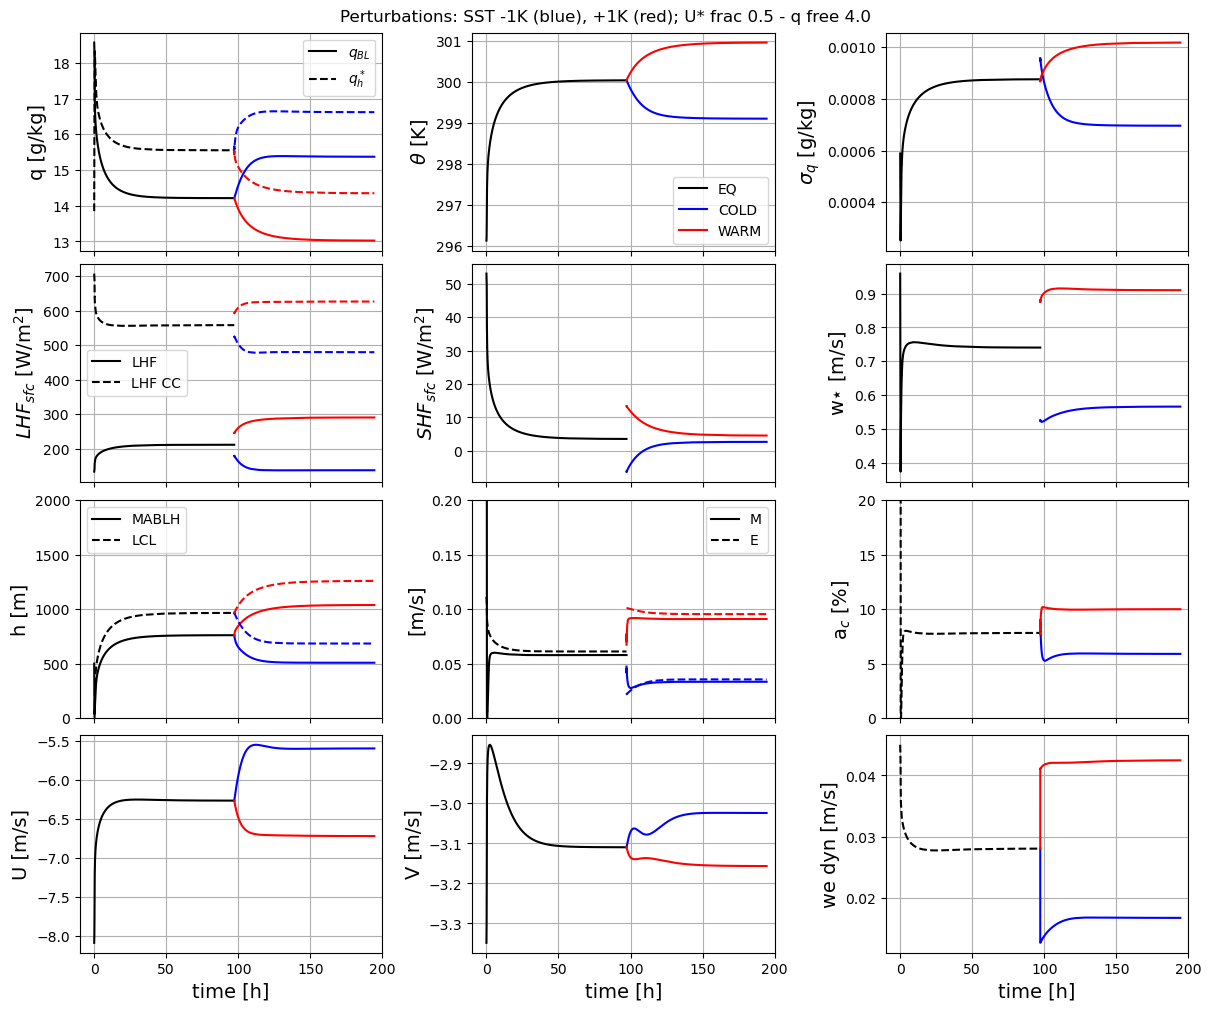

In [80]:
fig, ax = plt.subplots(4,3,figsize=(12,10),sharex=True,constrained_layout=True)
fig.suptitle(f'Perturbations: SST -1K (blue), +1K (red); U* frac {frac_Ustar} - q free {q_free_0*1000}')
import matplotlib.lines as mlines




##### temperature  ######
ax[0,1].plot(sol_NS_eq.t/3600,th_eq,'k', label='EQ')
ax[0,1].plot(sol_NS_eqPert_cold.t/3600,th_cold,'blue', label='COLD')
ax[0,1].plot(sol_NS_eqPert_warm.t/3600,th_warm,'r', label='WARM')
ax[0,1].set_ylabel(r'$\theta$ [K]',fontsize=14)
# ax[0,1].set_ylim(0,20)
ax[0,1].grid()
ax[0,1].legend(loc='best')

############## moisture  ##########
solid_line = mlines.Line2D([], [], color='k', label=r'$q_{BL}$', linestyle='-')
dashed_line = mlines.Line2D([], [], color='k', label=r'$q^*_{h}$', linestyle='--')
ax[0,0].plot(sol_NS_eq.t/3600,q_eq*1e3,'k')
ax[0,0].plot(sol_NS_eqPert_cold.t/3600,q_cold*1e3,'blue')
ax[0,0].plot(sol_NS_eqPert_warm.t/3600,q_warm*1e3,'r')
ax[0,0].plot(time_ext_NS_eq/3600, np.array(dict_ext_NS_eq['qsat_ext'])*1e3,'--k')
ax[0,0].plot(time_ext_NS_cold/3600, np.array(dict_ext_NS_eqPert_cold['qsat_ext'])*1e3,'--b')
ax[0,0].plot(time_ext_NS_warm/3600, np.array(dict_ext_NS_eqPert_warm['qsat_ext'])*1e3,'--r')
ax[0,0].set_ylabel('q [g/kg]',fontsize=14)
# ax[0,0].set_ylim(0,20)
ax[0,0].grid()
ax[0,0].legend(handles=[solid_line, dashed_line])




######  LHF  #####
solid_line = mlines.Line2D([], [], color='k', label='LHF', linestyle='-')
dashed_line = mlines.Line2D([], [], color='k', label='LHF CC', linestyle='--')
ax[1,0].plot(time_ext_NS_eq/3600, np.array(dict_ext_NS_eq['LHF_ext']),'k', label='LHF_eq')
ax[1,0].plot(time_ext_NS_cold/3600, np.array(dict_ext_NS_eqPert_cold['LHF_ext']),'b', label='LHF_cold')
ax[1,0].plot(time_ext_NS_warm/3600, np.array(dict_ext_NS_eqPert_warm['LHF_ext']),'r', label='LHF_warm')
ax[1,0].plot(time_ext_NS_eq/3600, np.array(dict_ext_NS_eq['LHF_CC_ext']),'--k', label='LHF CC eq')
ax[1,0].plot(time_ext_NS_cold/3600, np.array(dict_ext_NS_eqPert_cold['LHF_CC_ext']),'--b', label='LHF CC cold')
ax[1,0].plot(time_ext_NS_warm/3600, np.array(dict_ext_NS_eqPert_warm['LHF_CC_ext']),'--r', label='LHF CC warm')
ax[1,0].set_ylabel(r'$LHF_{sfc}$ [W/m$^2$]',fontsize=14)
# ax[1,0].set_ylim(0,500)
ax[1,0].grid()
ax[1,0].legend(handles=[solid_line, dashed_line])

######  SHF  #####
ax[1,1].plot(time_ext_NS_eq/3600, np.array(dict_ext_NS_eq['SHF_ext']),'k', label='SHF_eq')
ax[1,1].plot(time_ext_NS_cold/3600, np.array(dict_ext_NS_eqPert_cold['SHF_ext']),'b', label='SHF_cold')
ax[1,1].plot(time_ext_NS_warm/3600, np.array(dict_ext_NS_eqPert_warm['SHF_ext']),'r', label='SHF_warm')
ax[1,1].set_ylabel(r'$SHF_{sfc}$ [W/m$^2$]',fontsize=14)
# ax[1,1].set_ylim(0,500)
ax[1,1].grid()





#################  h and LCL  ##################
solid_line = mlines.Line2D([], [], color='k', label='MABLH', linestyle='-')
dashed_line = mlines.Line2D([], [], color='k', label='LCL', linestyle='--')
ax[2,0].plot(sol_NS_eq.t/3600,h_eq,'k')
ax[2,0].plot(sol_NS_eqPert_cold.t/3600,h_cold,'b')
ax[2,0].plot(sol_NS_eqPert_warm.t/3600,h_warm,'r')
## LCL ##
ax[2,0].plot(time_ext_NS_eq/3600, np.array(dict_ext_NS_eq['LCL_ext']),'--k')
ax[2,0].plot(time_ext_NS_cold/3600, np.array(dict_ext_NS_eqPert_cold['LCL_ext']),'--b')
ax[2,0].plot(time_ext_NS_warm/3600, np.array(dict_ext_NS_eqPert_warm['LCL_ext']),'--r')
ax[2,0].set_ylabel('h [m]',fontsize=14)
ax[2,0].set_ylim(0,2e3)
ax[2,0].grid()
ax[2,0].legend(handles=[solid_line, dashed_line], loc='upper left')



#########  M and E  ############
# Create custom legend handles for solid and dashed lines
solid_line = mlines.Line2D([], [], color='k', label='M', linestyle='-')
dashed_line = mlines.Line2D([], [], color='k', label='E', linestyle='--')
ax[2,1].plot(time_ext_NS_eq/3600, np.array(dict_ext_NS_eq['M_ext']),'k', label='M_eq')
ax[2,1].plot(time_ext_NS_cold/3600, np.array(dict_ext_NS_eqPert_cold['M_ext']),'b', label='M_cold')
ax[2,1].plot(time_ext_NS_warm/3600, np.array(dict_ext_NS_eqPert_warm['M_ext']),'r', label='M_warm')

ax[2,1].plot(time_ext_NS_eq/3600, np.array(dict_ext_NS_eq['E_ext']),'--k', label='E_eq')
ax[2,1].plot(time_ext_NS_cold/3600, np.array(dict_ext_NS_eqPert_cold['E_ext']),'--b', label='E_cold')
ax[2,1].plot(time_ext_NS_warm/3600, np.array(dict_ext_NS_eqPert_warm['E_ext']),'--r', label='E_warm')
ax[2,1].set_ylim(0,0.2)
ax[2,1].grid()
ax[2,1].legend(handles=[solid_line, dashed_line])
ax[2,1].set_ylabel('[m/s]',fontsize=14)



#######  wind  ######
# ax[3,0].hlines(U_free,np.min(sol_NS_eq.t/3600),np.max(sol_NS_eq.t/3600),'k',linestyle='dashed')
ax[3,0].plot(sol_NS_eq.t/3600, U_eq, 'k')
ax[3,0].plot(sol_NS_eqPert_cold.t/3600, U_cold,'blue')
ax[3,0].plot(sol_NS_eqPert_warm.t/3600, U_warm,'r')
ax[3,0].set_ylabel('U [m/s]',fontsize=14)
#ax[3,0].set_ylim(0,0.10)
ax[3,0].grid()

# ax[3,1].hlines(V_free,np.min(sol_NS_eq.t/3600),np.max(sol_NS_eq.t/3600),'k',linestyle='dashed')
ax[3,1].plot(sol_NS_eq.t/3600, V_eq, 'k')
ax[3,1].plot(sol_NS_eqPert_cold.t/3600, V_cold,'blue')
ax[3,1].plot(sol_NS_eqPert_warm.t/3600, V_warm,'r')
ax[3,1].set_ylabel('V [m/s]',fontsize=14)
#ax[3,1].set_ylim(0,0.10)
ax[3,1].grid()




#### what's left ####
ax[0,-1].plot(time_ext_NS_eq/3600, np.array(dict_ext_NS_eq['sigma_q_ext']),'k', label='eq')
ax[0,-1].plot(time_ext_NS_cold/3600, np.array(dict_ext_NS_eqPert_cold['sigma_q_ext']),'b', label='cold')
ax[0,-1].plot(time_ext_NS_warm/3600, np.array(dict_ext_NS_eqPert_warm['sigma_q_ext']),'r', label='warm')
ax[0,-1].set_ylabel('$\\sigma_q$ [g/kg]',fontsize=14)
# ax[0,-1].set_ylim(0,1.5)
ax[0,-1].grid()

ax[1,-1].plot(time_ext_NS_eq/3600, np.array(dict_ext_NS_eq['w_star_ext']),'k', label='eq')
ax[1,-1].plot(time_ext_NS_cold/3600, np.array(dict_ext_NS_eqPert_cold['w_star_ext']),'b', label='cold')
ax[1,-1].plot(time_ext_NS_warm/3600, np.array(dict_ext_NS_eqPert_warm['w_star_ext']),'r', label='warm')
ax[1,-1].set_ylabel('w$\star$ [m/s]',fontsize=14)
# ax[1,-1].set_ylim(0.3,1.2)
ax[1,-1].grid()


ax[2,-1].plot(time_ext_NS_eq/3600, np.array(dict_ext_NS_eq['area_c_ext'])*100,'--k', label='ac_eq')
ax[2,-1].plot(time_ext_NS_cold/3600, np.array(dict_ext_NS_eqPert_cold['area_c_ext'])*100,'b', label='ac_cold')
ax[2,-1].plot(time_ext_NS_warm/3600, np.array(dict_ext_NS_eqPert_warm['area_c_ext'])*100,'r', label='ac_warm')
ax[2,-1].set_ylabel('a$_c$ [%]',fontsize=14)
ax[2,-1].set_ylim(0,20)
ax[2,-1].grid()


ax[3,-1].plot(time_ext_NS_eq/3600, np.array(dict_ext_NS_eq['we_dyn_ext']),'--k', label='we_eq')
ax[3,-1].plot(np.insert((time_ext_NS_cold/3600), 0, time_ext_NS_eq[-1]/3600), np.insert(np.array(dict_ext_NS_eqPert_cold['we_dyn_ext']), 0, np.array(dict_ext_NS_eq['we_dyn_ext'])[-1]),'b', label='we_cold')
ax[3,-1].plot(np.insert((time_ext_NS_cold/3600), 0, time_ext_NS_eq[-1]/3600), np.insert(np.array(dict_ext_NS_eqPert_warm['we_dyn_ext']), 0, np.array(dict_ext_NS_eq['we_dyn_ext'])[-1]),'r', label='we_warm')
ax[3,-1].set_ylabel('we dyn [m/s]',fontsize=14)
# ax[3,-1].set_ylim(0,20)
ax[3,-1].grid()



ax[3,0].set_xlabel('time [h]',fontsize=14)
ax[3,1].set_xlabel('time [h]',fontsize=14)
ax[3,2].set_xlabel('time [h]',fontsize=14)
ax[3,0].set_xlim(-10,200)
ax[3,1].set_xlim(-10,200)
ax[3,2].set_xlim(-10,200)

# filename = '/venus/tesi_ale/img_bulk/SST_PlusMinus1_BoxModel_E1.pdf'
# print(filename)
# # plt.savefig(filename)
# del filename

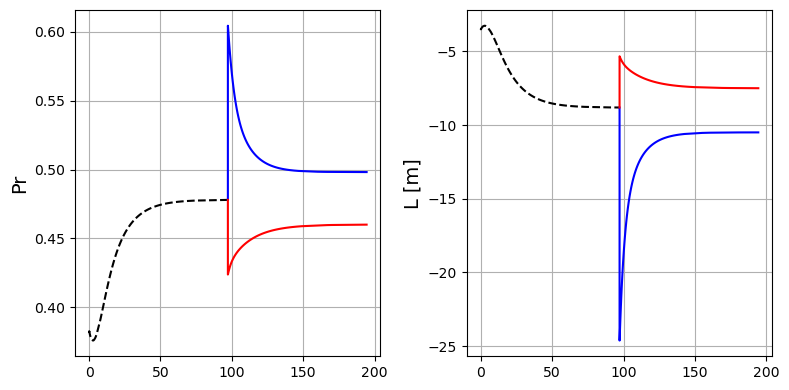

In [71]:
## plotting evolution of Pr and L
Pr_eq = np.array(dict_ext_NS_eq['we_dyn_ext'])/np.array(dict_ext_NS_eq['E_ext'])
Pr_cold = np.array(dict_ext_NS_eqPert_cold['we_dyn_ext'])/np.array(dict_ext_NS_eqPert_cold['E_ext'])
Pr_warm = np.array(dict_ext_NS_eqPert_warm['we_dyn_ext'])/np.array(dict_ext_NS_eqPert_warm['E_ext'])

z = 10     # this is fixed in the model
L_eq =    16*z/(1-Pr_eq**(-4))
L_cold =  16*z/(1-Pr_cold**(-4))
L_warm =  16*z/(1-Pr_warm**(-4))


fig, ax = plt.subplots(1,2,figsize=(8,4))

ax[0].plot(time_ext_NS_eq/3600, Pr_eq,'--k', label='we_eq')
ax[0].plot(np.insert((time_ext_NS_cold/3600), 0, time_ext_NS_eq[-1]/3600), np.insert(Pr_cold, 0, Pr_eq[-1]),'b', label='we_cold')
ax[0].plot(np.insert((time_ext_NS_cold/3600), 0, time_ext_NS_eq[-1]/3600), np.insert(Pr_warm, 0, Pr_eq[-1]),'r', label='we_warm')
ax[0].set_ylabel('Pr',fontsize=14)
# ax[0].set_ylim(0,20)
ax[0].grid()


ax[1].plot(time_ext_NS_eq/3600, L_eq,'--k', label='we_eq')
ax[1].plot(np.insert((time_ext_NS_cold/3600), 0, time_ext_NS_eq[-1]/3600), np.insert(L_cold, 0, L_eq[-1]),'b', label='we_cold')
ax[1].plot(np.insert((time_ext_NS_cold/3600), 0, time_ext_NS_eq[-1]/3600), np.insert(L_warm, 0, L_eq[-1]),'r', label='we_warm')
ax[1].set_ylabel('L [m]',fontsize=14)
# ax[1].set_ylim(0,20)
ax[1].grid()


plt.tight_layout()


## test sensitivity of wind field

In [19]:
from scipy.integrate import solve_ivp

In [35]:
pdist_sst_forced = np.load('/venus/tesi_ale/data_bulk/sensitivities/pdist_sst_forced.npy')
collect_eq = {}
collect_eq = {'SST values': pdist_sst_forced}

In [36]:
# Compute the wind components (to be used as free tropospheric wind) starting from the surface wind used in 
# Neggers et al (2006).
magnitude = 8.75 # [m/s]
angle = 67.5 # [°] clockwise from north
windu = magnitude*np.sin(angle*np.pi/180)
windv = magnitude*np.cos(angle*np.pi/180)
print(windu)
print(windv)

Omega = 2*np.pi/86400 # [rad/s] Earth rotation.
latitude0 = 10 # degree N
f = Omega * np.sin(latitude0*np.pi/180)

8.083945909473758
3.348480033194536


In [37]:
#############################   CHOICE OF MODEL FIRST THING FIRST  #################################
equations_model = neggers_stevens.neggers_et_al_2006_stevens_et_al_2002_fracUstar


# Now test the dependence of the solution to some external parameters.

#######################  set parameters and initial conditions from here on  #####################

U_free = -windu # [m/s], free zonal wind (above the ABL).
V_free = -windv # [m/s], free meridional wind (above the ABL).
we = 0.01 # [m/s], entrainment velocity for the horizontal velocity.

frac_Ustar = 0.9       # added this among the function args


# Input parameters
#V = 8.75            # [m/s], large scale horizontal wind -> no longer needed!
# SST = 300.4        # [K], sea surface temperature
D = 4.3e-6         # [1/s], large scale divergence
q_free_ls = [4e-3, 7e-3, 10.0e-3]    # [kg/kg] free tropospheric total mixing ratio
th_free = 308      # [K], free tropospheric liquid virtual potential temperature

# Initial conditions: y0 = [h(0),q(0),th(0),U(0),V(0)]
cpd  = 1004.67                                   # J/K/kg, dry air specific heat at constant pressure
Rd = 287.1                                       # J/K/kg, dry air gas constant
ref_p = 1000                                     # [hPa], reference pressure for the potential temperature: is this the surface pressure????
ps = ref_p                                        # [hPa], surface pressure
# th_s = SST*(ref_p/ps)**(Rd/cpd)                  # surface liquid water potential temperature, assuming no liquid water at the surface
# q_s = neggers_stevens.qsea(SST-273.15,ps)*1e-3


max_t = 7e5
dt_max = 60
time = [0, max_t]
factor_time = 0.5;  t_split = factor_time*max_t
# t_eval_eq = np.arange(0,t_split,dt_max)
# t_eval_cold_warm = np.arange(t_split,max_t,dt_max)


dict_params = {
        'SST forced': {'values':pdist_sst_forced, 'units':'K'},
        'SST': {'values': np.arange(299,301.1,0.1), 'units': 'K'},
        'U_free': {'values': np.arange(U_free-5,U_free+5, 1), 'units': 'm/s'},
        'V_free': {'values': np.arange(V_free-5,V_free+5, 0.5), 'units': 'm/s'}, 
        'D': {'values': np.arange(2.5,6.5,0.25)*1e-6, 'units': '1/s'},
        'q_free': {'values': np.arange(1e-3,14.0e-3,1e-3), 'units': 'kg/kg'}, 
        'th_free': {'values': np.arange(306,310, 0.2), 'units': 'K'},
        'ps': {'values': np.arange(1000,1030,5), 'units': 'hPa'},
        'E_frac': {'values': np.linspace(0.01, 2, 20), 'units': 'dimensionless'}
}

param_of_interest = 'SST forced'
list_of_values = dict_params[param_of_interest]['values']
str_units = dict_params[param_of_interest]['units']

#---------
for q_free in q_free_ls:
    
    h_eq = np.zeros((len(list_of_values),))
    q_eq = h_eq.copy()
    th_eq = h_eq.copy()
    U_eq, V_eq = h_eq.copy(), h_eq.copy()
    a_c_eq = h_eq.copy()
    w_star_eq = h_eq.copy()
    we_dyn_eq = h_eq.copy()
    M_eq = h_eq.copy()
    E_eq = h_eq.copy()
    LHF_eq = h_eq.copy()
    LHF_CC_eq = h_eq.copy()
    qs_eq = h_eq.copy()
    qsat_eq = h_eq.copy()
    SHF_eq = h_eq.copy()
    LCL_eq = h_eq.copy()
    sigma_q_eq = h_eq.copy()
    
    C_delta_q_eq = h_eq.copy()
    C_delta_th_eq = h_eq.copy() 
    q_flux_s_eq = h_eq.copy()
    th_flux_s_eq = h_eq.copy()

    for jj, SST in enumerate(list_of_values):
        ii=0


        dict_ext = {'area_c_ext':[], 'w_star_ext':[], 'M_ext':[], 'E_ext':[], 'LHF_ext':[], 'LHF_CC_ext':[], 'qs_ext':[], 'qsat_ext':[],\
                    'SHF_ext':[], 'LCL_ext':[], 'sigma_q_ext':[], 'we_dyn_ext':[], 'b_flux_s_NoG_ext':[],\
                    'C_delta_q':[], 'C_delta_th':[], 'q_flux_s':[], 'th_flux_s':[]}

        th_s = SST*(ref_p/ps)**(Rd/cpd)               
        q_s = neggers_stevens.qsea(SST-273.15,ps)*1e-3
        y0 = [100, q_s - q_free, th_s-3, U_free, V_free]


        sol = solve_ivp(equations_model, time, y0, dense_output=True, max_step=dt_max, args=(SST, D, q_free, th_free, ps, f, U_free, V_free, we, dict_ext, frac_Ustar))
        h_eq[jj] = sol.y[0][-1]
        LCL_eq[jj] = dict_ext['LCL_ext'][-1]       if len(dict_ext['LCL_ext']) is not 0 else 999

        q_eq[jj] = sol.y[1][-1]
        th_eq[jj] = sol.y[2][-1]
        U_eq[jj] = sol.y[3][-1]
        V_eq[jj] = sol.y[4][-1]

        a_c_eq[jj] = dict_ext['area_c_ext'][-1]    if len(dict_ext['area_c_ext']) is not 0 else 999
        w_star_eq[jj] = dict_ext['w_star_ext'][-1] if len(dict_ext['w_star_ext']) is not 0 else 999
        we_dyn_eq[jj] = dict_ext['we_dyn_ext'][-1] if len(dict_ext['we_dyn_ext']) is not 0 else 999
        M_eq[jj] = dict_ext['M_ext'][-1]           if len(dict_ext['M_ext']) is not 0 else 999
        E_eq[jj] = dict_ext['E_ext'][-1]           if len(dict_ext['E_ext']) is not 0 else 999

        LHF_eq[jj] = dict_ext['LHF_ext'][-1]       if len(dict_ext['LHF_ext']) is not 0 else 999
        LHF_CC_eq[jj] = dict_ext['LHF_CC_ext'][-1] if len(dict_ext['LHF_CC_ext']) is not 0 else 999
        SHF_eq[jj] = dict_ext['SHF_ext'][-1]       if len(dict_ext['SHF_ext']) is not 0 else 999

        qs_eq[jj] = dict_ext['qs_ext'][-1]         if len(dict_ext['qs_ext']) is not 0 else 999
        qsat_eq[jj] = dict_ext['qsat_ext'][-1]     if len(dict_ext['qsat_ext']) is not 0 else 999

        sigma_q_eq[jj] = dict_ext['sigma_q_ext'][-1]  if len(dict_ext['sigma_q_ext']) is not 0 else 999
        
        C_delta_q_eq[jj]  = dict_ext['C_delta_q'][-1]
        C_delta_th_eq[jj] = dict_ext['C_delta_th'][-1]
        q_flux_s_eq[jj]   = dict_ext['q_flux_s'][-1]
        th_flux_s_eq[jj]  = dict_ext['th_flux_s'][-1]


    print(str(q_free*1e3) + ' g/kg case done')


    ## this is for different values of q_free
    dict_eq = { 'M_eq':[], 'E_eq':[], 'LHF_eq':[], 'LHF_CC_eq':[], 'qs_eq':[], 'qsat_eq':[],\
                'SHF_eq':[], 'LCL_eq':[], 'we_dyn_eq':[], 'h_eq':[], 'q_eq':[], 'th_eq':[], 'U_eq':[], 'V_eq':[],\
              'C_delta_q_eq':[], 'C_delta_th_eq':[], 'q_flux_s_eq':[], 'th_flux_s_eq':[]}


    dict_eq['h_eq'] = h_eq
    dict_eq['LCL_eq'] = LCL_eq

    dict_eq['q_eq'] = q_eq
    dict_eq['th_eq'] =  th_eq
    dict_eq['U_eq'] = U_eq
    dict_eq['V_eq'] = V_eq

    dict_eq['we_dyn_eq'] =  we_dyn_eq
    dict_eq['M_eq'] = M_eq          
    dict_eq['E_eq'] = E_eq         

    dict_eq['LHF_eq'] = LHF_eq       
    dict_eq['LHF_CC_eq'] =  LHF_CC_eq
    dict_eq['SHF_eq'] = SHF_eq     

    dict_eq['qs_eq'] =  qs_eq       
    dict_eq['qsat_eq'] =  qsat_eq   
    
    dict_ext['C_delta_q_eq'] = C_delta_q_eq
    dict_ext['C_delta_th_eq'] = C_delta_th_eq
    dict_ext['q_flux_s_eq'] = q_flux_s_eq
    dict_ext['th_flux_s_eq'] = th_flux_s_eq

    collect_eq[str(q_free*1000)] = dict_eq
    print(collect_eq.keys())

4.0 g/kg case done
dict_keys(['SST values', '4.0'])
7.0 g/kg case done
dict_keys(['SST values', '4.0', '7.0'])
10.0 g/kg case done
dict_keys(['SST values', '4.0', '7.0', '10.0'])


In [38]:
collect_eq.keys()

dict_keys(['SST values', '4.0', '7.0', '10.0'])

In [39]:
collect_eq['frac_Ustar'] = frac_Ustar

In [40]:
frac_Ustar

0.9

In [41]:
import pickle

path = '/venus/tesi_ale/data_bulk/sensitivities/SST_sens_VaryingQFree_fracUstar09_allForcingTerms.pickle'
with open(path, 'wb') as handle:
    pickle.dump(collect_eq, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print('file saved')

file saved


# load bulk data

In [12]:
'''path = '/venus/tesi_ale/data_bulk/sensitivities/SST_sens_VaryingQFree_fracUstar07.pickle'
with open(path, 'rb') as handle:
    collect_eq = pickle.load(handle)'''

SST_forced = collect_eq['SST values']
collect_eq.pop('SST values')


array([298.69082642, 298.99957275, 299.17059326, 299.30218506,
       299.41305542, 299.50689697, 299.59078979, 299.66952515,
       299.74584961, 299.81939697, 299.88983154, 299.95932007,
       300.0274353 , 300.09402466, 300.16131592, 300.23284912,
       300.31008911, 300.39743042, 300.51516724, 300.79766846])

In [13]:
label_fracUstar = collect_eq['frac_Ustar']
collect_eq.pop('frac_Ustar')

0.9

No handles with labels found to put in legend.


/venus/tesi_ale/img_bulk/sensitivities/SST_sens_FullNS_varying_Qfree_SSTForced_frac-Ustar09.pdf


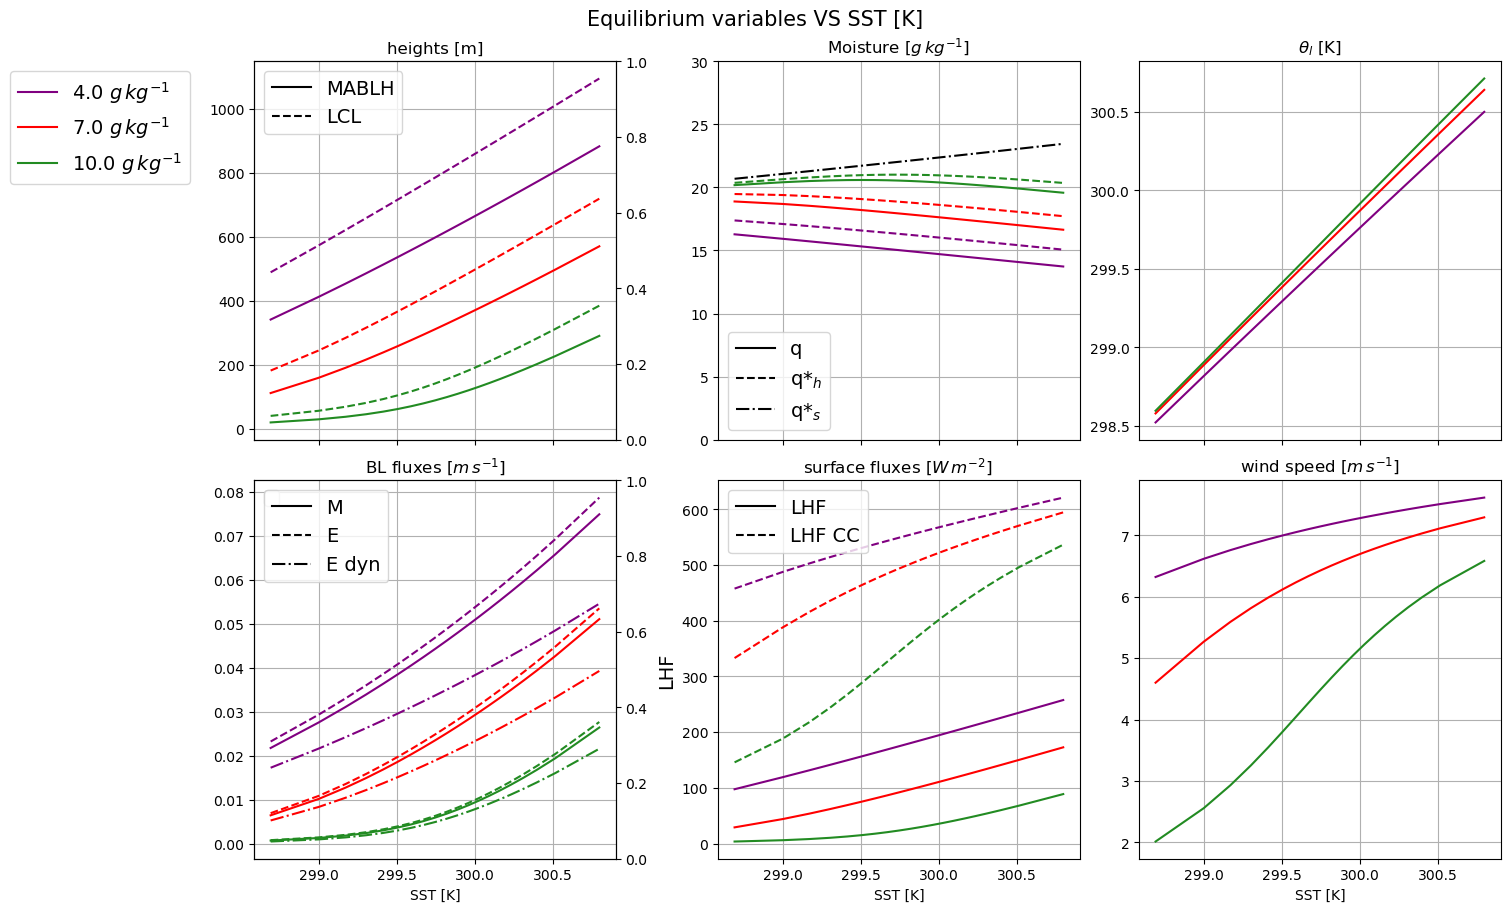

In [18]:
sys.path.append('/home/alessandro/thesis_material/EURECA_scripts/ABL_BULK/')
import neggers_stevens
import matplotlib.lines as mlines
#################################################################################################



param_of_interest = 'SST'; str_units = 'K'; label_model = 'Full'

colors = ['purple', 'red', 'forestgreen', 'darkblue']
legend_entries = [ str(float(x)) for x in collect_eq.keys()]

fig, ax = plt.subplots(2,3,figsize=(15,9),sharex=True,constrained_layout=True)
# fig.suptitle('Equilibrium variables VS '+param_of_interest+' ['+str_units+']'+f' model {label_model}',fontsize=16) #, E frac {E_frac}
# fig.suptitle('Equilibrium variables VS '+param_of_interest+' ['+str_units+'] ,' + r' varying $q_{free}$; '+f' U* frac: {label_fracUstar}' ,fontsize=16) #, E frac {E_frac}
fig.suptitle('Equilibrium variables VS '+param_of_interest+' ['+str_units+']', fontsize=15)



#########  h and LCL  ###########
solid_line = mlines.Line2D([], [], color='k', label='MABLH', linestyle='-')
dashed_line = mlines.Line2D([], [], color='k', label='LCL', linestyle='--')
ax[0,0].set_title('heights [m]')
ax[0,0].grid()

for i, moist in enumerate(collect_eq.keys()):
    ax[0,0].plot(SST_forced, collect_eq[moist]['h_eq'], '-', color=colors[i], label=legend_entries[i]+r' $g\,kg^{-1}$')
    ax[0,0].plot(SST_forced, collect_eq[moist]['LCL_eq'], '--', color=colors[i])

ax[0,0].legend(fontsize=14, bbox_to_anchor=(-0.15, 1))
finto = ax[0,0].twinx()
finto.legend(handles=[solid_line, dashed_line], loc='upper left', fontsize=14)


#########  moisture  ##########
solid_line = mlines.Line2D([], [], color='k', label='q', linestyle='-')
dashed_line = mlines.Line2D([], [], color='k', label='q*$_h$', linestyle='--')
ax[0,1].set_title(r'Moisture [$g\,kg^{-1}$]')
ax[0,1].grid()
ax[0,1].set_ylim(0,30)

q_star = ax[0,1].plot(SST_forced, neggers_stevens.qsea(SST_forced-273.15,1000), '-.k', label='q*$_s$')

for i, moist in enumerate(collect_eq.keys()):
    ax[0,1].plot(SST_forced, collect_eq[moist]['q_eq'] * 1e3, '-', color=colors[i])
    ax[0,1].plot(SST_forced, collect_eq[moist]['qsat_eq'] * 1e3, '--', color=colors[i])

ax[0,1].legend(fontsize=14)
ax[0,1].legend(handles=[solid_line, dashed_line, q_star[0]], loc='lower left',  fontsize=14)




#######  temperature  ########
ax[0,2].set_title(r'$\theta_l$ [K]')
ax[0,2].grid()

for i, moist in enumerate(collect_eq.keys()):
    ax[0,2].plot(SST_forced, collect_eq[moist]['th_eq'],  '-', color=colors[i],)

    
    
    
    

######  entrainment M and E ######
solid_line = mlines.Line2D([], [], color='k', label='M', linestyle='-')
dashed_line = mlines.Line2D([], [], color='k', label='E', linestyle='--')
dashdot_line = mlines.Line2D([], [], color='k', label='E dyn', linestyle='-.')
ax[1,0].set_title(r'BL fluxes [$m\,s^{-1}$]')
ax[1,0].grid()

for i, moist in enumerate(collect_eq.keys()):
    ax[1,0].plot(SST_forced, collect_eq[moist]['M_eq'],  '-', color=colors[i])
    ax[1,0].plot(SST_forced, collect_eq[moist]['E_eq'],  '--', color=colors[i])
    ax[1,0].plot(SST_forced, collect_eq[moist]['we_dyn_eq'],  '-.', color=colors[i])

ax[1,0].legend(fontsize=14)
finto = ax[1,0].twinx()
finto.legend(handles=[solid_line, dashed_line, dashdot_line], loc='upper left', fontsize=14)




# ##############  HEAT FLUXES  ################
solid_line = mlines.Line2D([], [], color='k', label='LHF', linestyle='-')
dashed_line = mlines.Line2D([], [], color='k', label='LHF CC', linestyle='--')
# dashdot_line = mlines.Line2D([], [], color='k', label='SHF', linestyle=':')
ax[1,1].set_title(r'surface fluxes [$W\,m^{-2}$] ')
ax[1,1].grid()
# twinni = ax[1,1].twinx()
ax[1,1].set_ylabel('LHF', fontsize=14)
# twinni.set_ylabel(r'SHF', fontsize=14)

for i, moist in enumerate(collect_eq.keys()):
    ax[1,1].plot(SST_forced, collect_eq[moist]['LHF_eq'],  '-', color=colors[i])
    ax[1,1].plot(SST_forced, collect_eq[moist]['LHF_CC_eq'],  '--', color=colors[i])
#     twinni.plot(SST_forced, collect_eq[moist]['SHF_eq'], ':', color=colors[i])

# lines_labels = ax[1,1].get_lines() + twinni.get_lines()  # Combine lines from both axes
# labels = ['LHF', 'LHF_CC', 'SHF']  # Custom labels for the combined legend
# ax[1,1].legend(lines_labels, labels, fontsize=14)
# finto = ax[1,1].twinx()
ax[1,1].legend(handles=[solid_line, dashed_line], loc='upper left', fontsize=14)



##### wind #####
# solid_line = mlines.Line2D([], [], color='k', label='U', linestyle='-')
# dashdot_line = mlines.Line2D([], [], color='k', label='V', linestyle='-.')
# ax[1,2].set_title(r'wind [$m\,s^{-1}$]')
# ax[1,2].set_ylabel('U', fontsize=14)
# ax[1,2].grid()
# axx = ax[1,2].twinx()
# axx.set_ylabel('V', fontsize=14)

# for i, moist in enumerate(collect_eq.keys()):
#     ax[1,2].plot(SST_forced, collect_eq[moist]['U_eq'],  '-',color=colors[i], label='U')
#     axx.plot(SST_forced, collect_eq[moist]['V_eq'],  '-.',color=colors[i], label='V')

# axx.legend(handles=[solid_line, dashdot_line], loc='upper right', fontsize=14)

ax[1,2].set_title(r'wind speed [$m\,s^{-1}$]')
# ax[1,2].set_ylabel('U', fontsize=14)
ax[1,2].grid()
# axx = ax[1,2].twinx()
# axx.set_ylabel('V', fontsize=14)

for i, moist in enumerate(collect_eq.keys()):
    ax[1,2].plot(SST_forced, np.sqrt(collect_eq[moist]['U_eq']**2 +  collect_eq[moist]['V_eq']**2),  '-',color=colors[i], label='U')

# axx.legend(handles=[solid_line, dashdot_line], loc='upper right', fontsize=14)


###########################################à

for i in range(3):
    ax[1,i].set_xlabel('SST [K]')

base_path = '/venus/tesi_ale/img_bulk/sensitivities/'+param_of_interest+'_sens_'
filename = base_path + 'FullNS' #if box_model_bool else base_path+'Full'
filename = filename + '_varying_Qfree_SSTForced_frac-Ustar09.pdf'
print(filename)
# plt.savefig(filename)



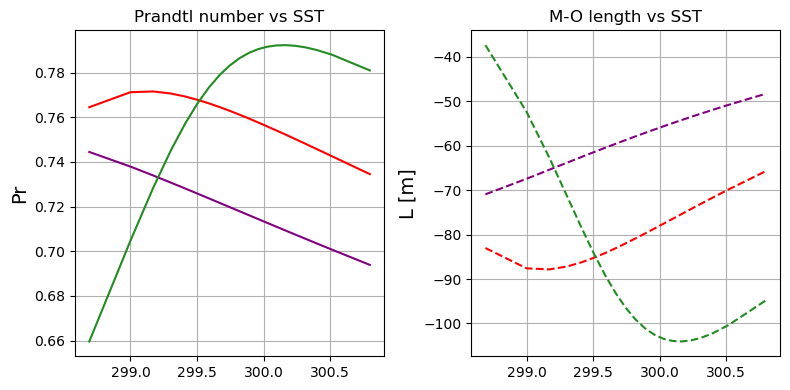

In [22]:
## plotting evolution of Pr and L
z = 10

fig, ax = plt.subplots(1,2,figsize=(8,4))

for i, moist in enumerate(collect_eq.keys()):
    pr = collect_eq[moist]['we_dyn_eq'] / collect_eq[moist]['E_eq']
    L = 16*z/(1-pr**(-4))
    
    ax[0].plot(SST_forced, pr,  '-', color=colors[i])
    ax[1].plot(SST_forced, L,  '--', color=colors[i])

ax[0].set_title('Prandtl number vs SST')
ax[0].set_ylabel('Pr',fontsize=14)
ax[0].grid('dashed')


ax[1].set_title('M-O length vs SST')
ax[1].grid('dashed')
ax[1].set_ylabel('L [m]',fontsize=14)

plt.tight_layout()
